In [80]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest,mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import ADASYN

In [81]:
dt=pd.read_csv("dataset.csv")
dt.head()

id  gender   age  hypertension  heart_disease ever_married  \
0  30669    Male   3.0             0              0           No   
1  30468    Male  58.0             1              0          Yes   
2  16523  Female   8.0             0              0           No   
3  56543  Female  70.0             0              0          Yes   
4  46136    Male  14.0             0              0           No   

      work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0      children          Rural              95.12  18.0              NaN   
1       Private          Urban              87.96  39.2     never smoked   
2       Private          Urban             110.89  17.6              NaN   
3       Private          Rural              69.04  35.9  formerly smoked   
4  Never_worked          Rural             161.28  19.1              NaN   

   stroke  
0       0  
1       0  
2       0  
3       0  
4       0

In [82]:
dt.shape

(43400, 12)

In [83]:
dt.isnull().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [84]:
dt.duplicated().sum()

0

# EDA

In [85]:
dt.describe().T

count          mean           std    min       25%  \
id                 43400.0  36326.142350  21072.134879   1.00  18038.50   
age                43400.0     42.217894     22.519649   0.08     24.00   
hypertension       43400.0      0.093571      0.291235   0.00      0.00   
heart_disease      43400.0      0.047512      0.212733   0.00      0.00   
avg_glucose_level  43400.0    104.482750     43.111751  55.00     77.54   
bmi                41938.0     28.605038      7.770020  10.10     23.20   
stroke             43400.0      0.018041      0.133103   0.00      0.00   

                        50%       75%       max  
id                 36351.50  54514.25  72943.00  
age                   44.00     60.00     82.00  
hypertension           0.00      0.00      1.00  
heart_disease          0.00      0.00      1.00  
avg_glucose_level     91.58    112.07    291.05  
bmi                   27.70     32.90     97.60  
stroke                 0.00      0.00      1.00

In [86]:
dt['stroke'].value_counts()

0    42617
1      783
Name: stroke, dtype: int64

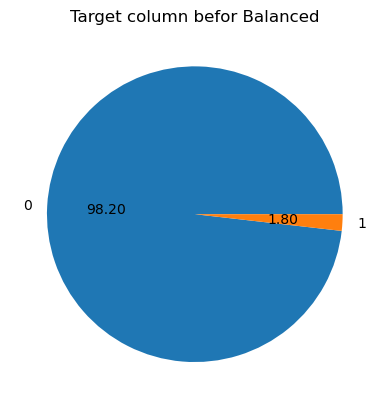

In [87]:
plt.pie(dt['stroke'].value_counts(),autopct='%.2f',labels=["0","1"])
palette_color = sns.color_palette('bright') 
plt.title("Target column befor Balanced")
plt.show()

In [88]:
# Above dataset is imbalanced

In [89]:
object_dt=dt.select_dtypes(include='object')

In [90]:
object_dt

gender ever_married     work_type Residence_type   smoking_status
0        Male           No      children          Rural              NaN
1        Male          Yes       Private          Urban     never smoked
2      Female           No       Private          Urban              NaN
3      Female          Yes       Private          Rural  formerly smoked
4        Male           No  Never_worked          Rural              NaN
...       ...          ...           ...            ...              ...
43395  Female           No      children          Urban     never smoked
43396  Female          Yes      Govt_job          Urban  formerly smoked
43397  Female          Yes       Private          Urban  formerly smoked
43398    Male          Yes       Private          Urban     never smoked
43399  Female          Yes       Private          Urban     never smoked

[43400 rows x 5 columns]

In [91]:
object_dt.nunique()

gender            3
ever_married      2
work_type         5
Residence_type    2
smoking_status    3
dtype: int64

In [92]:
dt.drop("id",axis=1,inplace=True)

In [93]:
object_dt.columns

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [94]:
catergorical_col=dt.select_dtypes(include="object")

In [95]:
# Encode categorical variables using Label Encoding means convert the cateogorical columns to numericals
label_encoders = {}
for col in catergorical_col:
    le = LabelEncoder()
    dt[col] = le.fit_transform(dt[col])
    label_encoders[col] = le

In [96]:
dt

gender   age  hypertension  heart_disease  ever_married  work_type  \
0           1   3.0             0              0             0          4   
1           1  58.0             1              0             1          2   
2           0   8.0             0              0             0          2   
3           0  70.0             0              0             1          2   
4           1  14.0             0              0             0          1   
...       ...   ...           ...            ...           ...        ...   
43395       0  10.0             0              0             0          4   
43396       0  56.0             0              0             1          0   
43397       0  82.0             1              0             1          2   
43398       1  40.0             0              0             1          2   
43399       0  82.0             0              0             1          2   

       Residence_type  avg_glucose_level   bmi  smoking_status  stroke  
0                   0              95.12  18.0               3       0  
1                   1              87.96  39.2               1       0  
2                   1             110.89  17.6               3       0  
3                   0              69.04  35.9               0       0  
4                   0             161.28  19.1               3       0  
...               ...                ...   ...             ...     ...  
43395               1              58.64  20.4               1       0  
43396               1             213.61  55.4               0       0  
43397               1              91.94  28.9               0       0  
43398               1              99.16  33.2               1       0  
43399               1              79.48  20.6               1       0  

[43400 rows x 11 columns]

In [97]:
dt.dropna(inplace=True)

# Feature Selection, Cross-Validation, and Data Splitting

In [98]:
# Separate features and labels
x=dt.drop(columns=['stroke'])
y=dt['stroke']

In [99]:
# Feature Selection
selector = SelectKBest(mutual_info_classif, k=10)
xnew = selector.fit_transform(x,y)

In [100]:
# Split the data
xtrain, xtemp, ytrain, ytemp = train_test_split(xnew, y, test_size=0.3, stratify=y, random_state=42)

In [101]:
xval, xtest, yval, ytest = train_test_split(xtemp, ytemp, test_size=0.5, stratify=ytemp, random_state=42)

In [102]:
print(xtrain.shape, xval.shape, xtest.shape)

(29356, 10) (6291, 10) (6291, 10)


# 5 classification algorithms

In [103]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'SVM': SVC(probability=True),
    'Neural Network': MLPClassifier(max_iter=1000)}

In [104]:
# Train and evaluate each model on the imbalanced dataset
baseline_results = {}

for name, model in models.items():
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xval)
    y_prob = model.predict_proba(xval)[:, 1]
    
    baseline_results[name] = {
        'Precision': classification_report(yval, y_pred, output_dict=True)['1']['precision'],
        'Recall': classification_report(yval, y_pred, output_dict=True)['1']['recall'],
        'F1-Score': classification_report(yval, y_pred, output_dict=True)['1']['f1-score'],
        'AUC-ROC': roc_auc_score(yval, y_prob)}

In [105]:
baseline_df = pd.DataFrame(baseline_results).T
print(baseline_df)

                     Precision    Recall  F1-Score   AUC-ROC
Logistic Regression        0.0  0.000000  0.000000  0.847601
Random Forest              0.0  0.000000  0.000000  0.747240
XGBoost                    0.4  0.020619  0.039216  0.807431
SVM                        0.0  0.000000  0.000000  0.362080
Neural Network             0.0  0.000000  0.000000  0.823569


#  CI Technique 1

In [106]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(xtrain, ytrain)

In [107]:
# Train and evaluate each model on the balanced dataset
smote_results = {}

for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(xval)
    y_prob = model.predict_proba(xval)[:, 1]
    
    smote_results[name] = {
        'Precision': classification_report(yval, y_pred, output_dict=True)['1']['precision'],
        'Recall': classification_report(yval, y_pred, output_dict=True)['1']['recall'],
        'F1-Score': classification_report(yval, y_pred, output_dict=True)['1']['f1-score'],
        'AUC-ROC': roc_auc_score(yval, y_prob)}

In [108]:
smote_df = pd.DataFrame(smote_results).T
print(smote_df)

                     Precision    Recall  F1-Score   AUC-ROC
Logistic Regression   0.048843  0.783505  0.091954  0.850570
Random Forest         0.125000  0.010309  0.019048  0.774008
XGBoost               0.100000  0.010309  0.018692  0.804482
SVM                   0.043113  0.845361  0.082041  0.844221
Neural Network        0.048924  0.515464  0.089366  0.784176


# CI technique 2

In [109]:
# Using Balanced Random Forest
balanced_rf = BalancedRandomForestClassifier(random_state=42)
balanced_rf.fit(xtrain, ytrain)

BalancedRandomForestClassifier(random_state=42)

In [110]:
# Evaluate each model on the validation set
results = {}

for name, model in models.items():
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xval)
    y_prob = model.predict_proba(xval)[:, 1]

    results[name] = {
        'Precision': classification_report(yval, y_pred, output_dict=True)['1']['precision'],
        'Recall': classification_report(yval, y_pred, output_dict=True)['1']['recall'],
        'F1-Score': classification_report(yval, y_pred, output_dict=True)['1']['f1-score'],
        'AUC-ROC': roc_auc_score(yval, y_prob)}

In [111]:
# Convert the results to a DataFrame for easy comparison
results_df = pd.DataFrame(results).T
print(results_df)

                     Precision    Recall  F1-Score   AUC-ROC
Logistic Regression        0.0  0.000000  0.000000  0.847601
Random Forest              0.0  0.000000  0.000000  0.785550
XGBoost                    0.4  0.020619  0.039216  0.807431
SVM                        0.0  0.000000  0.000000  0.637920
Neural Network             0.0  0.000000  0.000000  0.814706


# CI tehcnique 3

In [112]:
# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(xtrain, ytrain)

In [113]:
# Train and evaluate each model on the balanced dataset using ADASYN
adasyn_results = {}

for name, model in models.items():
    model.fit(X_train_adasyn, y_train_adasyn)
    y_pred = model.predict(xval)
    y_prob = model.predict_proba(xval)[:, 1]
    
    adasyn_results[name] = {
        'Precision': classification_report(yval, y_pred, output_dict=True)['1']['precision'],
        'Recall': classification_report(yval, y_pred, output_dict=True)['1']['recall'],
        'F1-Score': classification_report(yval, y_pred, output_dict=True)['1']['f1-score'],
        'AUC-ROC': roc_auc_score(yval, y_prob)}

In [114]:
adasyn_df = pd.DataFrame(adasyn_results).T
print(adasyn_df)

                     Precision    Recall  F1-Score   AUC-ROC
Logistic Regression   0.048580  0.793814  0.091558  0.850582
Random Forest         0.000000  0.000000  0.000000  0.754724
XGBoost               0.200000  0.020619  0.037383  0.811177
SVM                   0.042073  0.845361  0.080156  0.844236
Neural Network        0.061404  0.360825  0.104948  0.785810


In [115]:
# Combine all results for easy comparison
all_results = pd.concat([results_df, adasyn_df,smote_df], keys=['Balanced_rf', 'ADASYN',"SMOTE"])
print(all_results)

                                 Precision    Recall  F1-Score   AUC-ROC
Balanced_rf Logistic Regression   0.000000  0.000000  0.000000  0.847601
            Random Forest         0.000000  0.000000  0.000000  0.785550
            XGBoost               0.400000  0.020619  0.039216  0.807431
            SVM                   0.000000  0.000000  0.000000  0.637920
            Neural Network        0.000000  0.000000  0.000000  0.814706
ADASYN      Logistic Regression   0.048580  0.793814  0.091558  0.850582
            Random Forest         0.000000  0.000000  0.000000  0.754724
            XGBoost               0.200000  0.020619  0.037383  0.811177
            SVM                   0.042073  0.845361  0.080156  0.844236
            Neural Network        0.061404  0.360825  0.104948  0.785810
SMOTE       Logistic Regression   0.048843  0.783505  0.091954  0.850570
            Random Forest         0.125000  0.010309  0.019048  0.774008
            XGBoost               0.100000  0.01030